In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
# !wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
df = pd.read_csv('AirlineTweets.csv')

In [2]:
df_= df[['airline_sentiment','text']].copy()

In [3]:
target_map = {'positive':0, 'negative':2,'neutral':1}
df_['target'] = df_['airline_sentiment'].map(target_map)

In [4]:
df2 = df_[['text','target']]
df2.columns = ['sentence','label']
df2.to_csv('data.csv',index=None)

<Axes: >

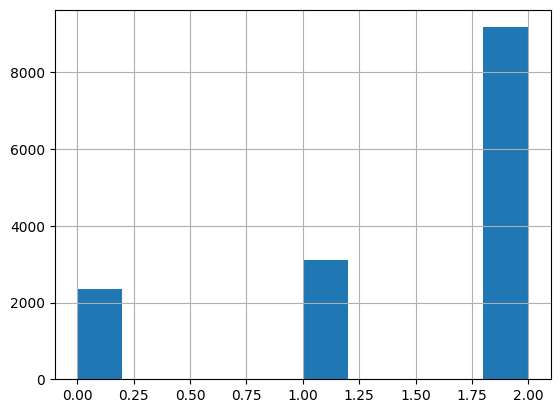

In [5]:
df2['label'].hist()

In [6]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [10]:
checkpoint = "distilbert-base-uncased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_fn(batch):
    return tokenizer(batch['sentence'],truncation=True)

tokenized_dataset = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForSequenceClassification, \
    Trainer, TrainingArguments

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [13]:
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
)

def compute_metrics(logits_and_labels):
    logits,labels = logits_and_labels
    predictions = np.argmax(logits,axis=1)
    acc = np.mean(predictions==labels)
    f1 = f1_score(labels,predictions,average='macro')
    return {'accuracy':acc,'f1':f1}



In [14]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: harelya (drumming_project). Use `wandb login --relogin` to force relogin


  0%|          | 0/1923 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.5337, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.41882169246673584, 'eval_accuracy': 0.8356102003642987, 'eval_f1': 0.774197552376083, 'eval_runtime': 11.8738, 'eval_samples_per_second': 369.891, 'eval_steps_per_second': 5.811, 'epoch': 1.0}
{'loss': 0.3552, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.458902508020401, 'eval_accuracy': 0.8438069216757741, 'eval_f1': 0.7876406560758555, 'eval_runtime': 11.5799, 'eval_samples_per_second': 379.279, 'eval_steps_per_second': 5.959, 'epoch': 2.0}
{'loss': 0.2325, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}


  0%|          | 0/69 [00:00<?, ?it/s]

{'eval_loss': 0.5600408315658569, 'eval_accuracy': 0.8401639344262295, 'eval_f1': 0.7856453460104994, 'eval_runtime': 11.5843, 'eval_samples_per_second': 379.134, 'eval_steps_per_second': 5.956, 'epoch': 3.0}
{'train_runtime': 359.2571, 'train_samples_per_second': 85.577, 'train_steps_per_second': 5.353, 'train_loss': 0.32964863333302863, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.32964863333302863, metrics={'train_runtime': 359.2571, 'train_samples_per_second': 85.577, 'train_steps_per_second': 5.353, 'train_loss': 0.32964863333302863, 'epoch': 3.0})

In [16]:
from transformers import pipeline

savemodel = pipeline('sentiment-analysis', model='training_dir/checkpoint-1923', device=0)


In [17]:

def get_label(d):
    return int(d['label'].split('_')[-1])

test_pred = savemodel(tokenized_dataset['test']['sentence'])
test_pred = [get_label(d) for d in test_pred]

In [18]:
print("acc: ",accuracy_score(split['test']['label'],test_pred))
print("f1: ",f1_score(split['test']['label'],test_pred,average='macro'))

acc:  0.8401639344262295
f1:  0.7856453460104994


In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(cm,classes):
    
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    cm_display.ax_.set_title('Confusion matrix')
    cm_display.ax_.set_xlabel('Predicted label')
    cm_display.ax_.set_ylabel('True label')
    cm_display.ax_.xaxis.set_ticklabels(classes)
    cm_display.ax_.yaxis.set_ticklabels(classes)
cm = confusion_matrix(split['test']['label'],test_pred,normalize='true')
classes = ['positive','neutral','negative']
plot_cm(cm,classes)

In [68]:
# df2['label']!= 1
df3 = df2[df2['label']!= 1]

In [78]:
df3.loc[df3['label'] == 2,'label'] = 1
df3.to_csv('data_2_classes.csv',index=None)

raw_dataset = load_dataset('csv', data_files='data_2_classes.csv')
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
tokenized_dataset = split.map(tokenize_fn, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/8078 [00:00<?, ? examples/s]

Map:   0%|          | 0/3463 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1515 [00:00<?, ?it/s]

{'loss': 0.2197, 'learning_rate': 3.34983498349835e-05, 'epoch': 0.99}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.18545332551002502, 'eval_accuracy': 0.9376263355472134, 'eval_f1': 0.8964964133900106, 'eval_runtime': 9.3732, 'eval_samples_per_second': 369.456, 'eval_steps_per_second': 5.868, 'epoch': 1.0}
{'loss': 0.1031, 'learning_rate': 1.6996699669966998e-05, 'epoch': 1.98}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.22454822063446045, 'eval_accuracy': 0.9396477043026278, 'eval_f1': 0.903471593440837, 'eval_runtime': 9.3562, 'eval_samples_per_second': 370.131, 'eval_steps_per_second': 5.878, 'epoch': 2.0}
{'loss': 0.0364, 'learning_rate': 4.950495049504951e-07, 'epoch': 2.97}


  0%|          | 0/55 [00:00<?, ?it/s]

{'eval_loss': 0.28889960050582886, 'eval_accuracy': 0.9434016748483973, 'eval_f1': 0.9079559890688684, 'eval_runtime': 9.2876, 'eval_samples_per_second': 372.864, 'eval_steps_per_second': 5.922, 'epoch': 3.0}
{'train_runtime': 282.7228, 'train_samples_per_second': 85.716, 'train_steps_per_second': 5.359, 'train_loss': 0.11868959220722564, 'epoch': 3.0}


TrainOutput(global_step=1515, training_loss=0.11868959220722564, metrics={'train_runtime': 282.7228, 'train_samples_per_second': 85.716, 'train_steps_per_second': 5.359, 'train_loss': 0.11868959220722564, 'epoch': 3.0})

acc:  0.9396477043026278
f1:  0.903471593440837


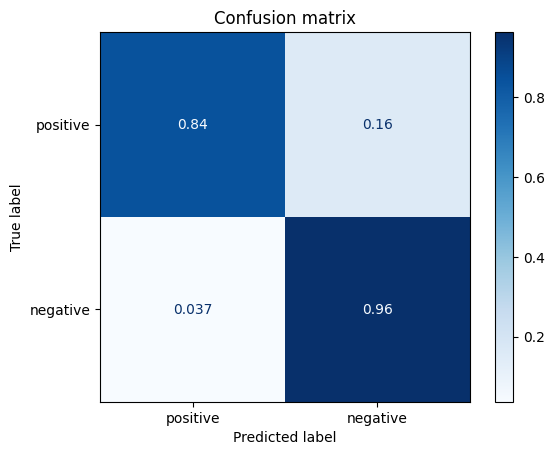

In [83]:
savemodel = pipeline('sentiment-analysis', model='training_dir/checkpoint-1010', device=0)
test_pred = savemodel(tokenized_dataset['test']['sentence'])
test_pred = [get_label(d) for d in test_pred]
print("acc: ",accuracy_score(split['test']['label'],test_pred))
print("f1: ",f1_score(split['test']['label'],test_pred,average='macro'))
cm = confusion_matrix(split['test']['label'],test_pred,normalize='true')
classes = ['positive','negative']
plot_cm(cm,classes)
# plot_cm(cm)